In [1]:
from cadcad.spaces import space
from cadcad.dynamics import block
from cadcad.spaces import Bit, Real, Integer
from cadcad.points import Point

import numpy as np

In [2]:
print(Bit)

Space Bit has dimensions {'bit': 'bool'}


In this notebook i will make a discrete time variant of a homocidal chaufeur

In [3]:

@space
class CartesianPlane:
    x:float
    y:float

CartesianPlaneDot = CartesianPlane.rename_dims({'x':'dx', 'y':'dy'})

@space
class Particle:
    pos:CartesianPlane
    vel:CartesianPlaneDot
    # used to encode a constraint
    #but this is exactly the kind of thing
    #i would like to push into the model params
    maxspeed : float

#this block serves as a kind of constraint checker for Particle
#i would like to be able to assign this block to the Space Paricle
#as a builtin constraint
@block
def isValidParticle(domain:Point[Particle])-> Point[Bit]:
    input = domain
    dx= input['vel']['dx']
    dy= input['vel']['dy']

    vmax = input['maxspeed']

    output = {'bit':bool(dx**2+dy**2<=vmax**2)}

    return Point(Bit, output)

@block
def projectValidParticle(domain:Point[Particle])-> Point[Particle]:
    input = domain

    bit = isValidParticle(input)
    output = input
    if not(bit['bit']):
        dx= input['vel']['dx']
        dy= input['vel']['dy']
        magnitude = np.sqrt(dx**2+dy**2)
        output['vel']['dx'] = dx/magnitude
        output['vel']['dy'] = dy/magnitude
      
    return output


print(Particle)
Particle.unroll_schema()

Space Particle has dimensions {'pos': 'CartesianPlane', 'vel': 'CartesianPlane', 'maxspeed': 'float'}


{'pos': {'x': 'float', 'y': 'float'},
 'vel': {'dx': 'float', 'dy': 'float'},
 'maxspeed': 'float'}

In [4]:
CartesianPlaneDot.unroll_schema()

{'dx': 'float', 'dy': 'float'}

In [5]:
initAlice = Point(Particle, {'pos': {'x': 1.0, 'y': 1.0},
 'vel': {'dx': -.2, 'dy': .2}, 'maxspeed':.2})

In [6]:
print(initAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.2,
        "dy": 0.2
    },
    "maxspeed": 0.2
}



In [7]:
print(isValidParticle(initAlice))

Point in space Bit has data
{
    "bit": false
}



In [8]:
print(projectValidParticle(initAlice))

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.7071067811865475,
        "dy": 0.7071067811865475
    },
    "maxspeed": 0.2
}



In [9]:
validInitAlice = projectValidParticle(initAlice)

In [10]:
Acc = CartesianPlane.rename_dims({'x':'ddx', 'y':'ddy'})
Acc.unroll_schema()

{'ddx': 'float', 'ddy': 'float'}

In [11]:
AliceUpdateDomain = (Particle * Acc).rename_dims({'cartesianplane':"acc"})
AliceUpdateDomain.unroll_schema()

{'particle': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'dx': 'float', 'dy': 'float'},
  'maxspeed': 'float'},
 'acc': {'ddx': 'float', 'ddy': 'float'}}

In [12]:
@block
def particleSubspace(domain: Point[AliceUpdateDomain])-> Point[Particle]:
    input = domain
    return Point(Particle, input.data['particle'])

In [13]:

@block
def aliceUpdate(domain:Point[AliceUpdateDomain])-> Point[Particle]:
    input = domain
    output = particleSubspace(input)

    output['pos']['x']  += input['particle']['vel']['dx']
    output['pos']['y']  += input['particle']['vel']['dy']

    output['vel']['dx']  += input['acc']['ddx']
    output['vel']['dy']  += input['acc']['ddy']

    output = projectValidParticle(output)

    return output
    

In [14]:
import json
def printPretty(nestedDict,sort_keys=True, indent=4):
    print(json.dumps(nestedDict,sort_keys=sort_keys, indent=indent))

In [15]:
alice_acc_data = {'acc':{'ddx':-.5, 'ddy':-.1 }}
alice_acc_data['particle'] = validInitAlice.data
printPretty(AliceUpdateDomain.unroll_schema())

{
    "acc": {
        "ddx": "float",
        "ddy": "float"
    },
    "particle": {
        "maxspeed": "float",
        "pos": {
            "x": "float",
            "y": "float"
        },
        "vel": {
            "dx": "float",
            "dy": "float"
        }
    }
}


In [16]:
printPretty(alice_acc_data)

{
    "acc": {
        "ddx": -0.5,
        "ddy": -0.1
    },
    "particle": {
        "maxspeed": 0.2,
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.7071067811865476,
            "dy": 0.7071067811865476
        }
    }
}


In [17]:
alice_update_input = Point(AliceUpdateDomain, alice_acc_data)

In [18]:

print(alice_update_input)

Point in space Particle*CartesianPlane has data
{
    "acc": {
        "ddx": -0.5,
        "ddy": -0.1
    },
    "particle": {
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.7071067811865476,
            "dy": 0.7071067811865476
        },
        "maxspeed": 0.2
    }
}



In [31]:
alice_new = aliceUpdate(alice_update_input)
print(initAlice)

Point in space Particle has data
{
    "pos": {
        "x": -1.5704624694046876,
        "y": 2.399596113342319
    },
    "vel": {
        "dx": -0.9952903163052005,
        "dy": 0.09693908535309241
    },
    "maxspeed": 0.2
}

Point in space Particle has data
{
    "pos": {
        "x": -1.5704624694046876,
        "y": 2.399596113342319
    },
    "vel": {
        "dx": -0.9952903163052005,
        "dy": 0.09693908535309241
    },
    "maxspeed": 0.2
}

Point in space Particle has data
{
    "pos": {
        "x": -1.5704624694046876,
        "y": 2.399596113342319
    },
    "vel": {
        "dx": -0.9952903163052005,
        "dy": 0.09693908535309241
    },
    "maxspeed": 0.2
}



In [32]:
print(validInitAlice)

Point in space Particle has data
{
    "pos": {
        "x": -1.5704624694046876,
        "y": 2.399596113342319
    },
    "vel": {
        "dx": -0.9952903163052005,
        "dy": 0.09693908535309241
    },
    "maxspeed": 0.2
}



In [33]:
print(alice_new)

Point in space Particle has data
{
    "pos": {
        "x": -1.5704624694046876,
        "y": 2.399596113342319
    },
    "vel": {
        "dx": -0.9952903163052005,
        "dy": 0.09693908535309241
    },
    "maxspeed": 0.2
}



Currently it appears that we are updating the earlier point `initAlice` in the process of creating the new point `validInitAlice` and `alice_new` since they all have the same value.

In [20]:
@space
class PolarPlane:
    r:float
    theta:float

PolarPlaneDot = PolarPlane.rename_dims({'r':'dr', 'theta':'dtheta'})

@space
class Unicycle:
    pos: PolarPlane
    vel: PolarPlaneDot

print(Unicycle)
Unicycle.unroll_schema()

Space Unicycle has dimensions {'pos': 'PolarPlane', 'vel': 'PolarPlane'}


{'pos': {'r': 'float', 'theta': 'float'},
 'vel': {'dr': 'float', 'dtheta': 'float'}}

In [21]:
PolarPlaneDot.unroll_schema()

{'dr': 'float', 'dtheta': 'float'}

In [22]:
@space
class GameState:
    alice: Particle
    bob: Unicycle

@space
class NormalizedGameState:
    alice: Particle
    bob: Particle

print(GameState)
GameState.unroll_schema()

Space GameState has dimensions {'alice': 'Particle', 'bob': 'Unicycle'}


{'alice': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'dx': 'float', 'dy': 'float'},
  'maxspeed': 'float'},
 'bob': {'pos': {'r': 'float', 'theta': 'float'},
  'vel': {'dr': 'float', 'dtheta': 'float'}}}

In [23]:


initBob = Point(Unicycle, {'pos': {'r': 1.0, 'theta': np.pi/4},
 'vel': {'dr': 1.0, 'dtheta': np.pi/8}})

init = Point(GameState, {'alice':initAlice.data, 'bob':initBob.data})

In [24]:
print(init)

Point in space GameState has data
{
    "alice": {
        "pos": {
            "x": 0.2928932188134524,
            "y": 1.7071067811865475
        },
        "vel": {
            "dx": -0.8933727790568017,
            "dy": 0.449316233448478
        },
        "maxspeed": 0.2
    },
    "bob": {
        "pos": {
            "r": 1.0,
            "theta": 0.7853981633974483
        },
        "vel": {
            "dr": 1.0,
            "dtheta": 0.39269908169872414
        }
    }
}



Alice is a Particle Trying to Evade the Unicycle Bob so she will attempt to maximize her distance from Bob in the Next timesteo

In [25]:
PolarPlaneDot.unroll_schema()

{'dr': 'float', 'dtheta': 'float'}

In [26]:
PolarPlane.unroll_schema()

{'r': 'float', 'theta': 'float'}

In [27]:
@block
def awkwardConverter1(domain:Point[PolarPlaneDot])->Point[PolarPlane]:
    """"""
    input = domain
    output = {}
    output['r'] = input['dr']
    output['theta'] = input['dtheta']

    return Point(PolarPlane, output)
    
@block
def awkwardConverter2(domain:Point[CartesianPlane])->Point[CartesianPlaneDot]:
    """needs """
    input = domain
    output = {}
    output['dx'] = input['x']
    output['dy'] = input['y']

    return Point(CartesianPlaneDot, output)

In [28]:
@block
def polar2cartesian(domain: Point[PolarPlane]) -> Point[CartesianPlane]:
    
    r = domain["r"]
    theta = domain["theta"]

    x = r*np.cos(theta)
    y = r*np.sin(theta)

    output = {"x":x, "y":y}

    return Point(CartesianPlane, output)

@block
def cartesian2polar(domain: Point[CartesianPlane]) -> Point[PolarPlane]:
    
    x = domain["x"]
    y = domain["y"]

    r = np.sqrt(x**2+y**2)
    if x==0:
        theta = np.sign(y)*np.pi/2
    else:
        theta = np.arctan(y/x)

    output = {"r":r, "theta":theta}

    return Point(PolarPlane, output)

@block
def normalize(domain:Point[GameState])->Point[NormalizedGameState]:
    #this is a piped block by hand
    #desired UX is to just write piping logic
    input=domain
    aliceData = input['alice']

    bobPosPolarPt = Point(PolarPlane, input['bob']['pos'])
    bobVelPolarDotPt = Point(PolarPlaneDot, input['bob']['vel'])
    print(bobVelPolarDotPt)
    bobVelPolarPt = awkwardConverter1(bobVelPolarDotPt)
    print(bobPosPolarPt)

    bobPosCartesian = polar2cartesian(bobPosPolarPt)

    bobVelCartesianTemp = polar2cartesian(bobVelPolarPt)
    print(bobVelCartesianTemp)

    bobVelCartesian=awkwardConverter2(bobVelCartesianTemp)
    print(bobVelCartesian)

    bobData = {'pos': bobPosCartesian.data, 'vel': bobVelCartesian.data}

    output = Point(NormalizedGameState, {'alice':aliceData, 'bob':bobData})

    return output



In [29]:
normalizedInit = normalize(init)

Point in space PolarPlane has data
{
    "dr": 1.0,
    "dtheta": 0.39269908169872414
}

Point in space PolarPlane has data
{
    "r": 1.0,
    "theta": 0.7853981633974483
}

Point in space CartesianPlane has data
{
    "x": 0.9238795325112867,
    "y": 0.3826834323650898
}

Point in space CartesianPlane has data
{
    "dx": 0.9238795325112867,
    "dy": 0.3826834323650898
}



ValueError: zip() argument 2 is shorter than argument 1

In [ ]:
print(init)

Point in space GameState has data
{
    "alice": {
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.2,
            "dy": 0.2
        }
    },
    "bob": {
        "pos": {
            "r": 1.0,
            "theta": 0.7853981633974483
        },
        "vel": {
            "dr": 1.0,
            "dtheta": 0.39269908169872414
        }
    }
}



In [ ]:
print(normalizedInit)

Point in space NormalizedGameState has data
{
    "alice": {
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.2,
            "dy": 0.2
        }
    },
    "bob": {
        "pos": {
            "x": 0.7071067811865476,
            "y": 0.7071067811865475
        },
        "vel": {
            "dx": 0.9238795325112867,
            "dy": 0.3826834323650898
        }
    }
}



In [ ]:
bobpos = [normalizedInit["bob"]["pos"]["x"], normalizedInit["bob"]["pos"]["y"]]
bobvelarrow = [normalizedInit["bob"]["pos"]["x"], 
                normalizedInit["bob"]["pos"]["y"], 
                normalizedInit["bob"]["vel"]["dx"],
                normalizedInit["bob"]["vel"]["dy"]]

alicepos = [normalizedInit["alice"]["pos"]["x"], normalizedInit["alice"]["pos"]["y"]]
alicevelarrow = [normalizedInit["alice"]["pos"]["x"], 
                normalizedInit["alice"]["pos"]["y"], 
                normalizedInit["alice"]["vel"]["dx"],
                normalizedInit["alice"]["vel"]["dy"]]


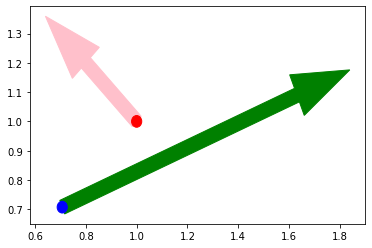

In [ ]:
from curses import color_content
import matplotlib.pyplot as plt
import matplotlib.patches as patches

normalizedInit["bob"]["pos"]["x"]
 
# Adding an arrow to graph starting
# from the base (2, 4) and with the
# length of 2 units from both x and y
# And setting the width of arrow for
# better visualization

plt.arrow(*alicevelarrow, width = 0.05, color="pink")
plt.arrow(*bobvelarrow, width = 0.05, color="green")
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)



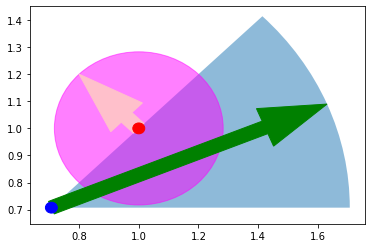

In [ ]:
bob_max_angle = np.pi/8
bob_max_speed = 1
alice_max_speed = np.sqrt(.2**2 + .2**2)

w = patches.Wedge(bobpos, bob_max_speed, (init["bob"]["vel"]["dtheta"]-bob_max_angle)*180/np.pi, (init["bob"]["vel"]["dtheta"]+bob_max_angle)*180/np.pi, alpha=.5)
plt.gca().add_patch(w)
c = plt.Circle(alicepos, radius=alice_max_speed, color="magenta", alpha=.5)
plt.gca().add_patch(c)
plt.arrow(*alicevelarrow, width = 0.05, color="pink", length_includes_head=True)
plt.arrow(*bobvelarrow, width = 0.05, color="green", length_includes_head=True)
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)


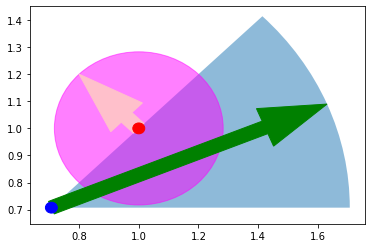

In [ ]:
bob_max_angle = np.pi/8
bob_max_speed = 1
alice_max_speed = np.sqrt(.2**2 + .2**2)

w = patches.Wedge(bobpos, bob_max_speed, (init["bob"]["vel"]["dtheta"]-bob_max_angle)*180/np.pi, (init["bob"]["vel"]["dtheta"]+bob_max_angle)*180/np.pi, alpha=.5)
plt.gca().add_patch(w)
c = plt.Circle(alicepos, radius=alice_max_speed, color="magenta", alpha=.5)
plt.gca().add_patch(c)
plt.arrow(*alicevelarrow, width = 0.05, color="pink", length_includes_head=True)
plt.arrow(*bobvelarrow, width = 0.05, color="green", length_includes_head=True)
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)